In [1]:
import sys
import os
import copy

ROOT_DIR = os.getcwd()
sys.path.insert(0, os.path.join(ROOT_DIR, ".."))
sys.path.insert(0, os.path.join(ROOT_DIR, "src"))
sys.path.insert(0, os.path.join(ROOT_DIR, "inerf_utils"))

import json
import torch
import numpy as np
import torchvision.transforms as T
import tqdm
import imageio
import cv2
import matplotlib.pyplot as plt
import wisp
from wisp.core import RenderBuffer, Rays


In [2]:
from wisp.framework import WispState
from inerf_utils import *
from kaolin.render.camera import Camera, blender_coords
from wisp.ops.raygen import generate_pinhole_rays, generate_centered_pixel_coords
from wisp.datasets import SampleRays
from wisp.trainers import MultiviewTrainer
from wisp.models.pipeline import Pipeline

def make_model(args, args_dict, extra_args, train_dataset, validation_dataset):
    pipeline = torch.load(args.pretrained)
    pipeline.to(extra_args['device'])
    scene_state = WispState()
    return pipeline
    # return pipeline

def gen_camera(pose, focal, w, h, far, extra_args):
    view_matrix = torch.zeros_like(pose)
    view_matrix[:3, :3] = pose[:3, :3].T
    view_matrix[:3, -1] = torch.matmul(-view_matrix[:3, :3], pose[:3, -1])
    view_matrix[3, 3] = 1.0

    x0 = 0.0
    y0 = 0.0

    camera = Camera.from_args(
        view_matrix=view_matrix,
        focal_x=focal,
        focal_y=focal,
        width=w,
        height=h,
        far=far,
        near=0.0,
        x0=x0,
        y0=y0,
        dtype=torch.float32,
        device=extra_args['device']
    )
    camera.change_coordinate_system(blender_coords())

    # mask = camera.extrinsics.gradient_mask('t')
    # camera.extrinsics.parameters.register_hook(lambda grad: grad * mask.float())
    
    return camera

def gen_rays_only(camera):
    ray_grid = generate_centered_pixel_coords(camera.width, camera.height, camera.width, camera.height, device=extra_args['device'])
    rays = generate_pinhole_rays(camera, ray_grid).reshape(camera.height, camera.width, 3)
    rays = Rays.stack(rays)
    return rays

# def gen_rays(pose, focal, w, h, far):
#     ray_grid = generate_centered_pixel_coords(camera.width, camera.height, camera.width, camera.height, device=extra_args['device'])
#     rays = generate_pinhole_rays(camera, ray_grid).reshape(camera.height, camera.width, 3)
#     # rays = Rays.stack(rays).to(dtype=torch.float)
    
#     return camera, rays

In [3]:
fig = px.line(x=xs, y=ys)
fig

NameError: name 'px' is not defined

In [ ]:
render_batch =  4000
def render_pipeline(pipeline, rays, lod_idx):
    rb = RenderBuffer(xyz=None, hit=None, normal=None, shadow=None, ao=None, dirs=None)
    for ray_pack in rays.split(render_batch):
        # print("haha")
        rb  += pipeline.tracer(pipeline.nef, rays=ray_pack, lod_idx=lod_idx)
    return rb

In [20]:
W, H = 200, 200
fx = (0.5 * H) / np.tan(0.5 * float(1.3213687585295282))
extra_args = {
  'resume' : True,
  'output' : './pose_estimation',
  'device' : 'cuda',
  'z_near' : 0.0,
  'z_far' : 10.0,
  'focal' : fx,
  'lrate' : 3e-2,
  'epochs': 20
}


In [21]:
def get_image(cam, pipeline):
    cam = copy.deepcopy(cam)

    rays = gen_rays_only(cam)
    rays = rays.reshape((rays.shape[0]**2, -1))

    rb = render_pipeline(pipeline, rays, lod_idx=None)
    rgb = rb.rgb.detach().cpu().numpy().reshape((H, W, 3))
    alpha = rb.alpha.detach().cpu().numpy().reshape((H, W, 1))
    # v = np.concatenate([rgb, alpha], axis=2)

    # return v
    return rgb, alpha

In [22]:
argv_base = [
    '--config=../app/nerf/configs/nerf_hash.yaml',
    '--pretrained=path_to_model',
    '--valid-only'
]

In [23]:
argv_base

['--config=../app/nerf/configs/nerf_hash.yaml',
 '--pretrained=path_to_model',
 '--valid-only']

In [24]:
sys.argv

['/home/saptarshi/miniconda3/envs/wisp2/lib/python3.9/site-packages/ipykernel_launcher.py',
 '--config=../app/nerf/configs/nerf_hash.yaml',
 '--pretrained=/home/saptarshi/dev/kaolin-wisp/_results_new/cheezit_single_side_env2_nobg_sam_scale10/model_5/20230424-184101/model.pth',
 '--valid-only']

In [25]:
model_name = "cheezit_single_side_env2_nobg_sam_scale10"
root_dir = '/home/saptarshi/dev/kaolin-wisp/_results_new/' + model_name + '/'

pipelines = []
for i in range(1,6):
    model_dir = os.path.join(root_dir, f"model_{i}")
    model_path = os.path.join(model_dir, list(sorted(os.listdir(model_dir)))[0], "model.pth")
    print(model_path)
    sys.argv[1:] = argv_base
    sys.argv[2] = sys.argv[2].replace("path_to_model", model_path)
    print(sys.argv[2])
    args, args_dict = parse_args()
    pipeline = make_model(
        args, args_dict, extra_args, None, None)
    pipelines.append(pipeline)

/home/saptarshi/dev/kaolin-wisp/_results_new/cheezit_single_side_env2_nobg_sam_scale10/model_1/20230424-183512/model.pth
--pretrained=/home/saptarshi/dev/kaolin-wisp/_results_new/cheezit_single_side_env2_nobg_sam_scale10/model_1/20230424-183512/model.pth
/home/saptarshi/dev/kaolin-wisp/_results_new/cheezit_single_side_env2_nobg_sam_scale10/model_2/20230424-183641/model.pth
--pretrained=/home/saptarshi/dev/kaolin-wisp/_results_new/cheezit_single_side_env2_nobg_sam_scale10/model_2/20230424-183641/model.pth
/home/saptarshi/dev/kaolin-wisp/_results_new/cheezit_single_side_env2_nobg_sam_scale10/model_3/20230424-183800/model.pth
--pretrained=/home/saptarshi/dev/kaolin-wisp/_results_new/cheezit_single_side_env2_nobg_sam_scale10/model_3/20230424-183800/model.pth
/home/saptarshi/dev/kaolin-wisp/_results_new/cheezit_single_side_env2_nobg_sam_scale10/model_4/20230424-183933/model.pth
--pretrained=/home/saptarshi/dev/kaolin-wisp/_results_new/cheezit_single_side_env2_nobg_sam_scale10/model_4/202304

In [26]:
initial_pose = torch.tensor([
    [
        -1.0, 
        -4.626498457856961e-16, 
        4.720679491933968e-16, 
        1.7628913879643898e-17
    ], 
    [
        5.311059178858428e-16,
        -0.6942281197690637, 
        0.7197550400809366, 
        0.28790201210533295
    ], 
    [
        -1.305182704980029e-16, 
        0.7197550400809366, 
        0.6942281197690636, 
        0.17220125197906527
    ], 
    [
        0.0, 
        0.0, 
        0.0, 
        1.0
    ]
])

cur_pose = torch.tensor([
    [
        -1.0, 
        -2.823936947407328e-17, 
        5.340285413173258e-16, 
        2.4463562574074363e-17
    ], 
    [
        3.5457582038357597e-16, 
        -0.04896000828076464, 
        0.9988007396819185, 
        0.3995202958290813
    ], 
    [
        -1.089239719165523e-17, 
        0.9988007396819186, 
        0.04896000828076479, 
        -0.08590599579648245
    ], 
    [
        0.0, 
        0.0, 
        0.0, 
        1.0
    ]
])

initial_pose[..., :3, 3] *= 10/1.25
cur_pose[..., :3, 3] *= 10/1.25

# initial_pose = cur_pose

In [37]:
z_near, z_far = extra_args['z_near'], extra_args['z_far']
camera = gen_camera(torch.clone(initial_pose).detach(), extra_args['focal'], W, H, z_far, extra_args)
camera.switch_backend('matrix_6dof_rotation')
camera.extrinsics.requires_grad = True

cur_cam = gen_camera(torch.clone(cur_pose).detach(), extra_args['focal'], W, H, z_far, extra_args)
cur_cam.switch_backend('matrix_6dof_rotation')
current_pose = cur_cam.extrinsics.parameters().clone()
current_pose_named = cur_cam.extrinsics.named_params()

> /home/saptarshi/miniconda3/envs/wisp2/lib/python3.9/site-packages/kaolin/render/camera/camera.py(387)from_args()
    385             _intrinsic_args['num_cameras'] = len(extrinsics)
    386         # import pdb; pdb.set_trace()
--> 387         intrinsics = intrinsic_ctor(**_intrinsic_args)
    388         return Camera(extrinsics=extrinsics, intrinsics=intrinsics)
    389 

> /home/saptarshi/miniconda3/envs/wisp2/lib/python3.9/site-packages/kaolin/render/camera/camera.py(387)from_args()
    385             _intrinsic_args['num_cameras'] = len(extrinsics)
    386         # import pdb; pdb.set_trace()
--> 387         intrinsics = intrinsic_ctor(**_intrinsic_args)
    388         return Camera(extrinsics=extrinsics, intrinsics=intrinsics)
    389 



In [38]:
# optimizer = torch.optim.Adam(params=[camera.extrinsics.parameters()], lr=extra_args['lrate'])
optimizer = torch.optim.Adam(params=[camera.extrinsics.parameters()], lr=extra_args['lrate'])


In [39]:
current_pose

tensor([[-1.0000e+00, -1.0892e-17, -3.5458e-16, -2.8239e-17,  9.9880e-01,
          4.8960e-02, -9.4506e-16,  8.4291e-01, -3.1587e+00]], device='cuda:0')

In [40]:

initial_pose

tensor([[-1.0000e+00, -4.6265e-16,  4.7207e-16,  1.4103e-16],
        [ 5.3111e-16, -6.9423e-01,  7.1976e-01,  2.3032e+00],
        [-1.3052e-16,  7.1976e-01,  6.9423e-01,  1.3776e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])

tensor([-9.4506e-16,  8.4291e-01, -3.1587e+00], device='cuda:0') tensor([-9.0242e-16,  6.0742e-01, -2.6141e+00], device='cuda:0',
       grad_fn=<IndexBackward0>)
0
torch.Size([40000, 3])
torch.Size([40000, 3])
1
torch.Size([40000, 3])
torch.Size([40000, 3])
2
torch.Size([40000, 3])
torch.Size([40000, 3])
3
torch.Size([40000, 3])
torch.Size([40000, 3])
4
torch.Size([40000, 3])
torch.Size([40000, 3])
torch.Size([40000])
tensor(1.6559, dtype=torch.float64, grad_fn=<RsubBackward1>) tensor(4.9308, device='cuda:0', grad_fn=<MeanBackward0>) tensor(1.6559, dtype=torch.float64, grad_fn=<RsubBackward1>)
ak
tensor(0, device='cuda:0')
ak
tensor(0, device='cuda:0')
ak
tensor(0, device='cuda:0')
ak
tensor(42, device='cuda:0')
ak
tensor(399, device='cuda:0')
ak
tensor(165, device='cuda:0')
ak
tensor(204, device='cuda:0')
ak
tensor(234, device='cuda:0')
ak
tensor(312, device='cuda:0')
ak
tensor(186, device='cuda:0')
ak
tensor(0, device='cuda:0')
ak
tensor(0, device='cuda:0')
ak
tensor(0, device='cuda

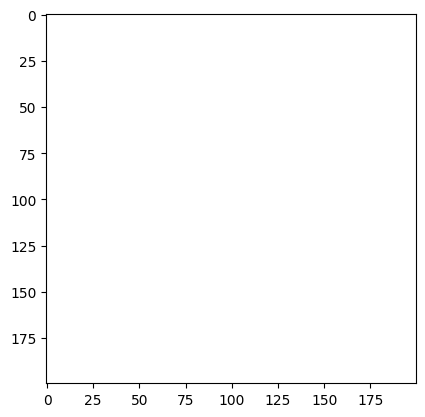

0
torch.Size([40000, 3])
torch.Size([40000, 3])
1
torch.Size([40000, 3])
torch.Size([40000, 3])
2
torch.Size([40000, 3])
torch.Size([40000, 3])
3
torch.Size([40000, 3])
torch.Size([40000, 3])
4
torch.Size([40000, 3])
torch.Size([40000, 3])
torch.Size([40000])
tensor(1.7321, dtype=torch.float64, grad_fn=<RsubBackward1>) tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>) tensor(1.7321, dtype=torch.float64, grad_fn=<RsubBackward1>)
ak
tensor(0, device='cuda:0')
ak
tensor(0, device='cuda:0')
ak
tensor(0, device='cuda:0')
ak
tensor(0, device='cuda:0')
ak
tensor(0, device='cuda:0')
ak
tensor(0, device='cuda:0')
ak
tensor(0, device='cuda:0')
ak
tensor(0, device='cuda:0')
ak
tensor(0, device='cuda:0')
ak
tensor(0, device='cuda:0')
ak
tensor(0, device='cuda:0')
ak
tensor(0, device='cuda:0')
ak
tensor(0, device='cuda:0')
ak
tensor(0, device='cuda:0')
ak
tensor(0, device='cuda:0')
ak
tensor(0, device='cuda:0')
ak
tensor(0, device='cuda:0')
ak
tensor(0, device='cuda:0')
ak
tensor(0, device='cud

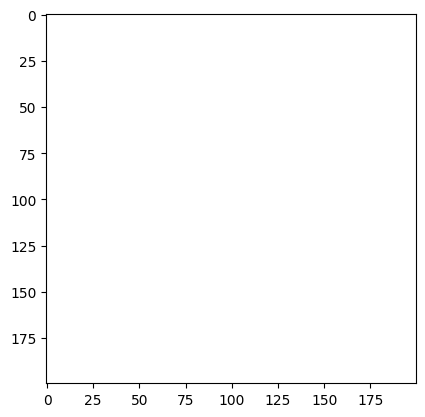

In [41]:
print(current_pose_named[0]['t'], camera.extrinsics.named_params()[0]['t'])
for ep in range(2):
    optimizer.zero_grad()

    rays = gen_rays_only(camera)
    rays = rays.reshape((rays.shape[0]**2, -1))
    
    all_rgbs = torch.ones((10, W*H, 3), dtype=float)
    for i, pipeline in enumerate(pipelines):
        print(i)
        rb = render_pipeline(pipeline, rays, None)
        print(rb.rgb.shape)
        print(all_rgbs[i,:,:].shape)
        all_rgbs[i,:,:] = rb.rgb
        # print(all_rgbs) 
    all_unc = torch.sqrt(torch.sum(torch.var(all_rgbs, axis = 0), axis = -1))
    print(all_unc.size())
    all_unc = torch.nn.functional.relu(all_unc)
    # print(all_unc)
    unc_loss = math.sqrt(3)-torch.mean(all_unc)
    # dist_loss = torch.mean((current_pose - camera.extrinsics.parameters())**2)
    # flip_loss = 
    dist_loss = torch.mean((current_pose_named[0]['t'] - camera.extrinsics.t )**2)

    loss = unc_loss 
    print(unc_loss, dist_loss, loss)

    loss.backward()
    optimizer.step()
    # del(all_rgbs)
    del(unc_loss)
    del(dist_loss)
    print(current_pose, camera.extrinsics.parameters())
    print(current_pose_named[0]['t'], camera.extrinsics.named_params()[0]['t'])
    print(camera.intrinsics.named_params())
    plt.imshow(get_image(camera, pipeline=pipelines[0])[0])
    plt.show()




In [ ]:
camera.extrinsics.named_params()[0]

{'R': tensor([nan, nan, nan, nan, nan, nan], device='cuda:0',
        grad_fn=<IndexBackward0>),
 't': tensor([nan, nan, nan], device='cuda:0', grad_fn=<IndexBackward0>)}

In [ ]:
camera.intrinsics.named_params()

[{'x0': 0.0,
  'y0': 0.0,
  'focal_x': 128.66665649414062,
  'focal_y': 128.66665649414062}]

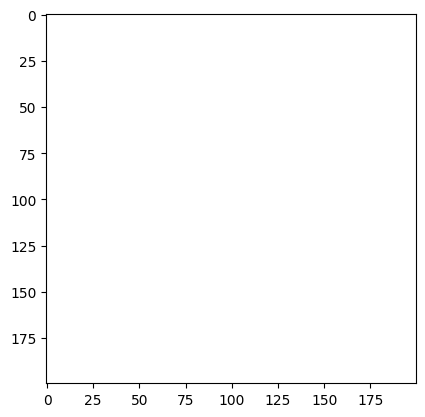

In [ ]:
plt.imshow(get_image(camera, pipeline=pipelines[0])[0])


In [ ]:
torch.tensor([[-1.0, -2.823936947407328e-17, 5.340285413173258e-16, 2.4463562574074363e-17], [3.5457582038357597e-16, -0.04896000828076464, 0.9988007396819185, 0.3995202958290813], [-1.089239719165523e-17, 0.9988007396819186, 0.04896000828076479, -0.08590599579648245], [0.0, 0.0, 0.0, 1.0]])

tensor([[-1.0000e+00, -2.8239e-17,  5.3403e-16,  2.4464e-17],
        [ 3.5458e-16, -4.8960e-02,  9.9880e-01,  3.9952e-01],
        [-1.0892e-17,  9.9880e-01,  4.8960e-02, -8.5906e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])

In [ ]:
gen_rays_only(camera)

Rays(origins=tensor([[[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        ...,

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, n

In [ ]:
camera.view_projection_matrix()

tensor([[[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]]], device='cuda:0', grad_fn=<BmmBackward0>)

In [ ]:
camera.named_params()

[{'R': tensor([nan, nan, nan, nan, nan, nan], device='cuda:0',
         grad_fn=<IndexBackward0>),
  't': tensor([nan, nan, nan], device='cuda:0', grad_fn=<IndexBackward0>),
  'x0': 0.0,
  'y0': 0.0,
  'focal_x': 128.66665649414062,
  'focal_y': 128.66665649414062}]

In [ ]:
initial_pose

tensor([[-1.0000e+00, -4.6265e-16,  4.7207e-16,  1.4103e-16],
        [ 5.3111e-16, -6.9423e-01,  7.1976e-01,  2.3032e+00],
        [-1.3052e-16,  7.1976e-01,  6.9423e-01,  1.3776e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])

In [ ]:
torch.inverse(camera.extrinsics.parameters().reshape((4,4)))

RuntimeError: shape '[4, 4]' is invalid for input of size 9

In [ ]:
camera.extrinsics.named_params()

In [ ]:
z_near, z_far = extra_args['z_near'], extra_args['z_far']
camera = gen_camera(torch.clone(initial_pose).detach(), extra_args['focal'], W, H, z_far, extra_args)


In [ ]:
camera.extrinsics.t

tensor([[[-1.1280e-15],
         [ 7.5927e-01],
         [-3.2677e+00]]], device='cuda:0', grad_fn=<SliceBackward0>)